In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

In [2]:
df_HFC = pd.read_excel('data/HighTurnover/HFC.xlsx', index_col=0)
y = pd.read_excel('data/Returns/Ret_Var.xlsx', index_col=0)

In [3]:
df_ind_mom = pd.read_excel('data/HighTurnover/Ind_Mom.xlsx', index_col=0)

In [4]:
df_irr = pd.read_excel('data/HighTurnover/IRR.xlsx', index_col=0)

In [5]:
predictors = [df_HFC, df_ind_mom, df_irr]
names=["HFC","ind_mom","irr"]

In [26]:
predictors_stacked = []
for i in range(len(predictors)):
    df_filled = predictors[i].fillna(method='bfill')
    df_filled = df_filled.fillna(0)
    print(df_filled.head)
    df_filled[pd.isna(y)] = np.NaN
    df_stack = df_filled.stack().dropna()
    df_stack.name = names[i]
    df_stack = df_stack.reset_index()
    predictors_stacked.append(df_stack)

<bound method NDFrame.head of            196307     196308     196309     196310     196311     196312  \
Permno                                                                     
10001   63.397548  58.714789   5.696757  80.122592  13.374126   5.866900   
10002   63.397548  58.714789   5.696757  80.122592  13.374126   5.866900   
10003   63.397548  58.714789   5.696757  80.122592  13.374126   5.866900   
10006   63.397548  58.714789   5.696757  80.122592  13.374126   5.866900   
10007   79.422067  85.299296  47.239264  75.831874  41.520979  20.402802   
...           ...        ...        ...        ...        ...        ...   
93432    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
93433    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
93434    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
93435    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
93436    0.000000   0.000000   0.000000   0.000000   0.000

In [27]:
predictors_stacked[0].shape

(2187349, 3)

In [28]:
res = predictors_stacked[0]
for i in range(1,len(predictors)):
    res = pd.merge(res, predictors_stacked[i], how="left", left_on=["Permno", "level_1"], right_on=["Permno", "level_1"])

In [29]:
res.head()

,Permno,level_1,HFC,ind_mom,irr
0,10001,198601,31.829574,5.0,67.474241
1,10001,198602,72.123043,8.0,29.991761
2,10001,198603,60.641479,3.0,37.292743
3,10001,198604,49.358632,3.0,48.717263
4,10001,198605,29.925651,2.0,66.861391


In [30]:
y_stack = y.stack().dropna()
y_stack.name = "return"
y_stack = y_stack.reset_index()
y_stack.head()

,Permno,level_1,return
0,10001,198601,0.000000
1,10001,198602,0.020408
2,10001,198603,0.025200
3,10001,198604,0.009901
4,10001,198605,-0.009804


In [31]:
print(res.shape)
print(y_stack.shape)

(2187349, 5)
(2187349, 3)


In [33]:
x_train, x_test = np.split(res.to_numpy()[:,2:], [1457474])
y_train, y_test = np.split(y_stack.to_numpy()[:,2:], [1457474])
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

print(y_test.shape)

(1457474, 3)
(1457474, 1)
(729875, 3)
(729875, 1)


In [34]:
reg = LinearRegression().fit(x_train, y_train)
print(mean_squared_error(y_test, reg.predict(x_test)))
print(r2_score(y_test, reg.predict(x_test)))

0.027847571019948395
0.0006524002213893487


In [35]:
MSEs = []
R2s = []
for i in range(198700,201900,100):
    x_train = res[res["level_1"] < i].to_numpy()[:,2:]
    y_train = y_stack[y_stack["level_1"] < i].to_numpy()[:,2:]
    x_test = res[(res["level_1"] >= i) & (res["level_1"] <= i + 100)].to_numpy()[:,2:]
    y_test = y_stack[(y_stack["level_1"] >= i) & (y_stack["level_1"] <= i + 100)].to_numpy()[:,2:]
    reg = LinearRegression().fit(x_train, y_train)
    MSEs.append(mean_squared_error(y_test, reg.predict(x_test)))
    R2s.append(r2_score(y_test, reg.predict(x_test)))

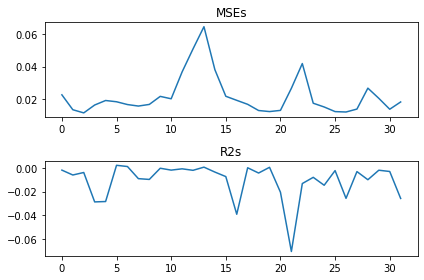

In [36]:
plt.subplot(2,1,1)
plt.plot(MSEs)
plt.title("MSEs")

plt.subplot(2,1,2)
plt.plot(R2s)
plt.title("R2s")

plt.tight_layout()

In [37]:
print(np.mean(MSEs))
print(np.mean(R2s))

0.021920594102669135
-0.010762392924509857


Last MSE and R^2 value with mean filling
0.021918890935935076
-0.010627932052457923